In [1]:
import os
import math
import pickle

import torch

from torch import device
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class EpochStat:
    @staticmethod
    def loadModelStats(dir, name, subdir) -> list['EpochStat']:
        return sorted([pickle.load(open(os.path.join(dir, subdir, file), 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(os.path.join(dir, subdir)))],
                      key=lambda e: e.epoch)

    def __init__(self, name, save_dir, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0):
        self.name = name
        self.save_dir = save_dir
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = []
        self.train_accuracies = []

    def save(self):
        os.makedirs(self.save_dir, exist_ok=True)
        pickle.dump(self, open(os.path.join(self.save_dir, self.name + '_e' + str(self.epoch) + '.pickle'), 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)

# Results plotting

## Plot by model

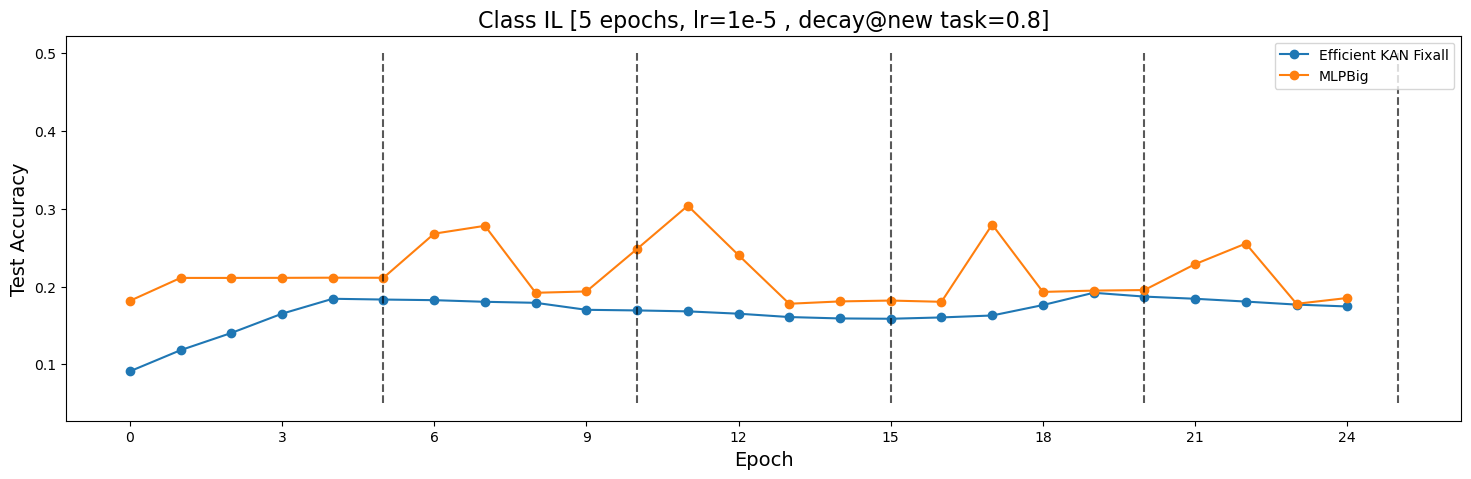

In [5]:
epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
epochs_list = [5]
lr_list = [1e-5]
decay_list = [0.8]
models = [Efficient_KAN_Fixall(strategy, device), MLPBig(strategy, device)]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path, 'trainings')


for epochs in epochs_list:
    for lr in lr_list:
        for decay_f in decay_list:
            if decay_f == 1:
                lr_decay = False
            else:
                lr_decay = True
            fig, ax = plt.subplots()

            sub_dir = f"ep{epochs}_lr{round(math.log10(lr))}{'_dec'+ str(decay_f) if lr_decay else ''}"
            for name in list(map(lambda e: e.__class__.__name__, models)):
                stats = EpochStat.loadModelStats(path, name, subdir=os.path.join(sub_dir, name))
                name_ = name.replace("_", " ").replace("_", " ").replace("Lin", "").replace("KANBN", "KAN BN").replace("KANBN", "KAN BN").replace("Net", "")
                ax.plot(list(map(lambda e: e.get_accuracy(), stats))[:], label=name_, marker='o')
            epochs_act = [epochs*(i+1) for i in range(5)]
            if epoch_sched:
                epochs_act = [0]
                for i in range(5):
                    epochs_act.append(int(epochs + epochs*i/2)+epochs_act[-1])
            plt.legend()
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.xlabel('Epoch', fontdict={'fontsize': 14})
            plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
            plt.title(f"Class IL {'(reversed tasks) ' if reverse_taks else ''}[{epochs} epochs, lr=1e{round(math.log10(lr))} {', decay@new task=' + str(decay_f) if lr_decay else ''}]", fontdict={'fontsize': 16})
            plt.vlines(x=epochs_act, ymin=0.05, ymax=0.5, colors='black', alpha=0.65, linestyles='dashed')
            fig.set_size_inches(18, 5)
            plt.show()
            # plt.savefig(os.path.join('.', 'results', dataset_name, 'domainIL_comp_ultimi', 'plots', "EffKANFix_vs_EffKANFixall",
            #                         f"ep_{epochs}_lr_{round(math.log10(lr))}{'_dec'+ str(decay_f) if lr_decay else ''}.png"))
            # plt.close()

## Plot by LR

In [ ]:
epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
epochs_list = [5]
lr_list = [1e-5]
decay_list = [0.8]
models = [Efficient_KAN_Fixall(strategy, device), MLPBig(strategy, device)]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path, 'trainings')

for epochs in epochs_list:
    for model in models:
        for decay_f in decay_list:
            if decay_f == 1:
                lr_decay = False
            else:
                lr_decay = True
            fig, ax = plt.subplots()
            
            name = model.__class__.__name__
            for lr in lr_list:
                sub_dir = f"ep{epochs}_lr{round(math.log10(lr))}{'_dec'+ str(decay_f) if lr_decay else ''}"
                stats = EpochStat.loadModelStats(path, name, subdir=os.path.join(sub_dir, name))
                name_ = name.replace("_", " ").replace("_", " ").replace("Lin", "").replace("KANBN", "KAN BN").replace("KANBN", "KAN BN").replace("Net", "")
                ax.plot(list(map(lambda e: e.get_accuracy(), stats))[:], label=name_, marker='o')
            epochs_act = [epochs*(i+1) for i in range(5)]
            if epoch_sched:
                epochs_act = [0]
                for i in range(5):
                    epochs_act.append(int(epochs + epochs*i/2)+epochs_act[-1])
                    plt.legend(lr_list)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.xlabel('Epoch', fontdict={'fontsize': 14})
            plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
            plt.title(f"Domain IL - {name} [{epochs} epochs, lr={round(math.log10(lr))}{', decay=' + str(decay_f) if lr_decay else ''}]", fontdict={'fontsize': 16})
            plt.vlines(x=epochs_act, ymin=0.05, ymax=0.5, colors='black', alpha=0.65, linestyles='dashed')
            fig.set_size_inches(18, 5)
            plt.show()

## Plot by LR Decay factor

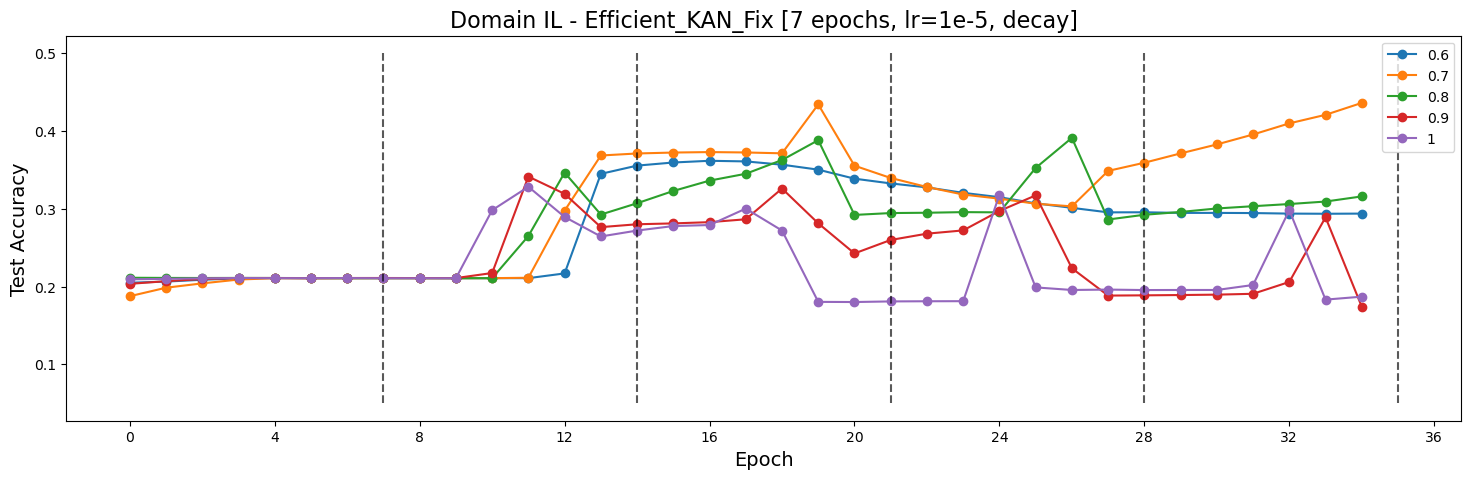

In [16]:
epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
epochs_list = [5]
lr_list = [1e-5]
decay_list = [0.8]
models = [Efficient_KAN_Fixall(strategy, device), MLPBig(strategy, device)]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path, 'trainings')

for epochs in epochs_list:
    for lr in lr_list:
        for model in models:
            fig, ax = plt.subplots()
            name = model.__class__.__name__
            
            for decay_f in decay_list:
                if decay_f == 1:
                    lr_decay = False
                else:
                    lr_decay = True
                sub_dir = f"ep{epochs}_lr{round(math.log10(lr))}{'_dec'+ str(decay_f) if lr_decay else ''}"
                stats = EpochStat.loadModelStats(path, name, subdir=os.path.join(sub_dir, name))
                name_ = name.replace("_", " ").replace("_", " ").replace("Lin", "").replace("KANBN", "KAN BN").replace("KANBN", "KAN BN").replace("Net", "")
                ax.plot(list(map(lambda e: e.get_accuracy(), stats))[:], label=name_, marker='o')
            epochs_act = [epochs*(i+1) for i in range(5)]
            if epoch_sched:
                epochs_act = [0]
                for i in range(5):
                    epochs_act.append(int(epochs + epochs*i/2)+epochs_act[-1])
                    plt.legend(lr_list)
            plt.legend(decay_list)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            plt.xlabel('Epoch', fontdict={'fontsize': 14})
            plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
            plt.title(f"Domain IL - {name} [{epochs} epochs, lr=1e{round(math.log10(lr))}, decay]", fontdict={'fontsize': 16})
            plt.vlines(x=epochs_act, ymin=0.05, ymax=0.5, colors='black', alpha=0.65, linestyles='dashed')
            fig.set_size_inches(18, 5)
            plt.show()

## Plot single cfgs

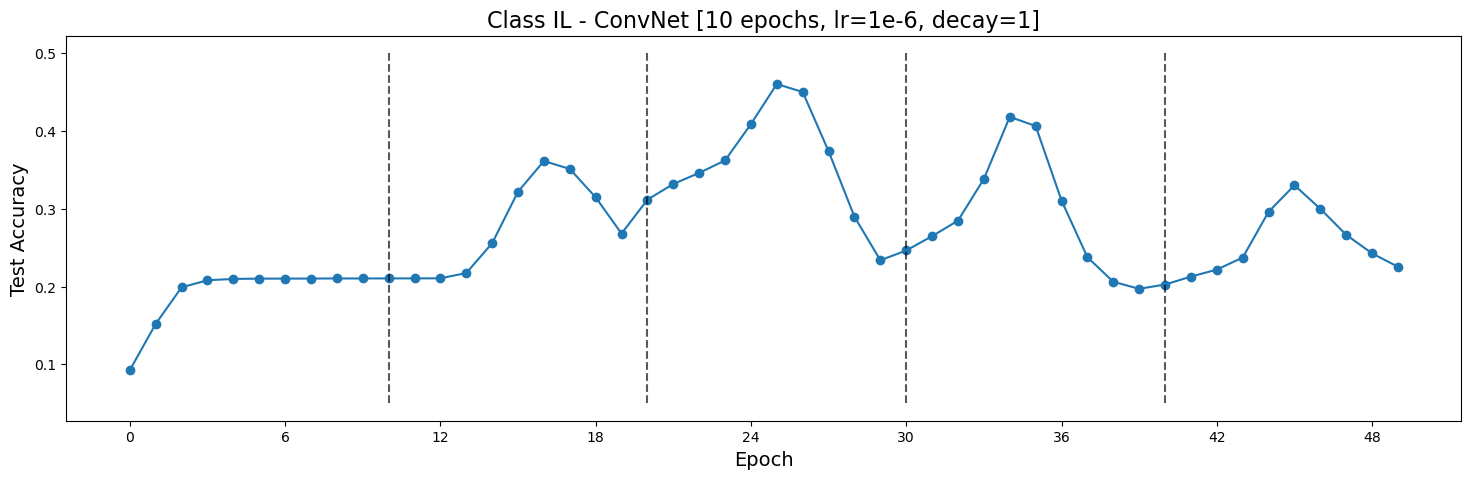

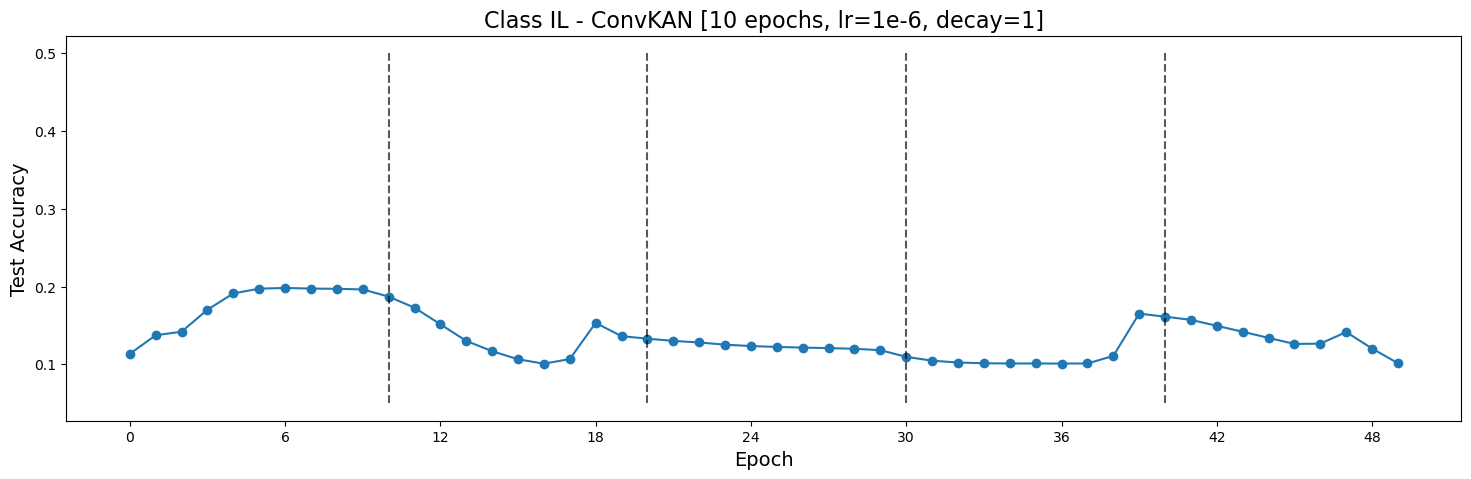

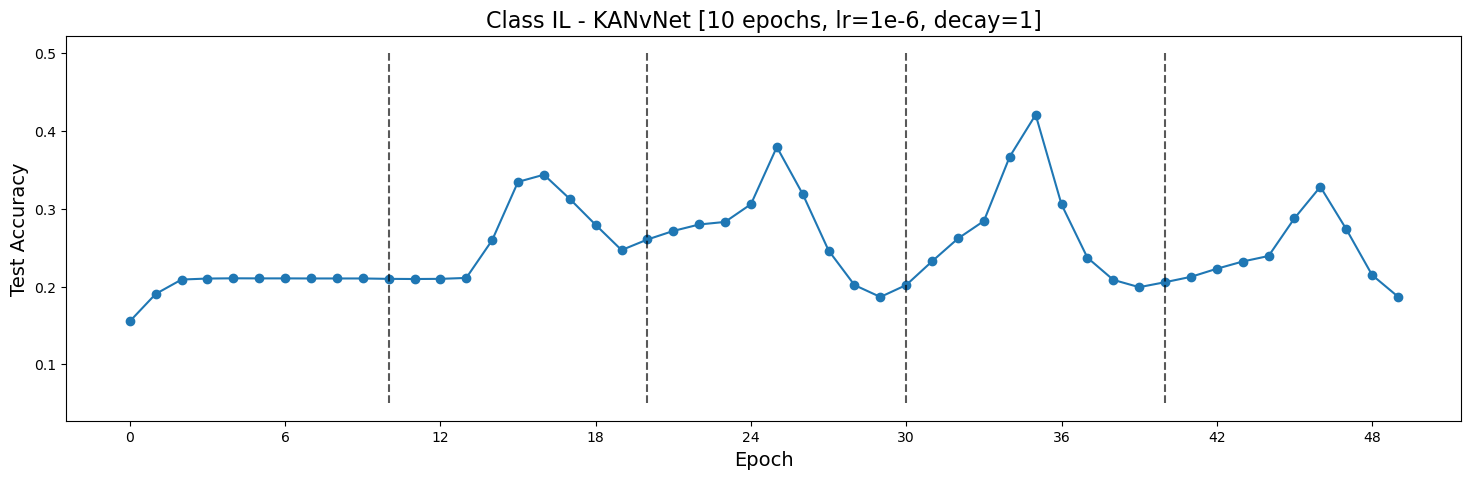

In [17]:
epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
cfgs = [
    [ConvNet_BN(strategy, device), "ConvNet", 10, 1e-6, 1],
    [ConvKANLinBN_Fixed(strategy, device), "ConvKAN", 10, 1e-6, 1],
    [KANvNet_BN_Fixed(strategy, device), "KANvNet", 10, 1e-6, 1]
]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path, 'trainings')

for cfg in cfgs:
    model = cfg[0]
    name = cfg[1]
    epochs = cfg[2]
    lr = cfg[3]
    decay_f = cfg[4]
    lr_decay = False if decay_f == 1 else True
    
    fig, ax = plt.subplots()
    file_name = f"ep{epochs}_lr{round(math.log10(lr))}{'_dec'+ str(decay_f) if lr_decay else ''}"
    stats = EpochStat.loadModelStats(path, model.__class__.__name__, subdir=os.path.join(file_name, model.__class__.__name__))
    ax.plot(list(map(lambda e: e.get_accuracy(), stats))[:], label=model.__class__.__name__, marker='o')
    # ax.plot(list(map(lambda e: e.train_accuracies, stats))[0][::granularity], label=name)
    # plt.legend(decay_fs)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Epoch', fontdict={'fontsize': 14})
    plt.ylabel('Test Accuracy', fontdict={'fontsize': 14})
    plt.title(f"Class IL - {name} [{epochs} epochs, lr=1e{round(math.log10(lr))}, decay={decay_f}]", fontdict={'fontsize': 16})
    plt.vlines(x=range(0, 5 * epochs, epochs)[1:], ymin=0.05, ymax=0.5, colors='black', alpha=0.65, linestyles='dashed')
    fig.set_size_inches(18, 5)
    if not os.path.exists(os.path.join(path, "plots", "best_accs")):
        os.makedirs(os.path.join(path, "plots", "best_accs"))
    plt.savefig(os.path.join(path, "plots", "best_accs", f"{name}.png"))
    plt.show()

## 3D plot (epochs, lr) --> max accuracy in the last task

In [7]:
def get_results(decay_f_list, lr_list, epochs_list, name, path):
    results = []      # [epochs, lr, decay_f, max_acc@5task]
    # epoch_sched = False
    for epochs in epochs_list:
        for lr in lr_list:
            for decay_f in decay_f_list:
                lr_decay = True
                if decay_f == 1:
                    lr_decay = False
                str_epoch = f"ep{epochs}" 
                # str_epoch += 'sched' if epoch_sched else ''
                str_decay = '_dec'+ str(decay_f) if lr_decay else ''
                str_lr = f"_lr{round(math.log10(lr))}"
                stats = EpochStat.loadModelStats(path, name, os.path.join(f"{str_epoch}{str_lr}{str_decay}", name))
                accs = list(map(lambda e: e.get_accuracy(), stats))[:]
                accs_last_task = accs[-epochs:]
                results.append([int(epochs), lr, decay_f, max(accs_last_task), accs.index(max(accs_last_task))])
    return results

### Extract best values

In [10]:
epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
epochs_list = [5]
lr_list = [1e-5]
decay_list = [0.8]
models_list = [Efficient_KAN_Fixall(strategy, device), MLPBig(strategy, device)]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path, 'trainings')

stats = []
for id, model in enumerate(models_list):
    stats.append((get_results(decay_list, lr_list, epochs_list, model.__class__.__name__, path)))
    max_acc = max(stats[-1], key=lambda v: v[-1])
    print(f"max acc for {model.__class__.__name__} :", max_acc)

max acc for Efficient_KAN_Fixall : [5, 1e-05, 0.8, 0.1871, 20]
max acc for MLPBig : [5, 1e-05, 0.8, 0.2553, 22]


## Scatter Plot

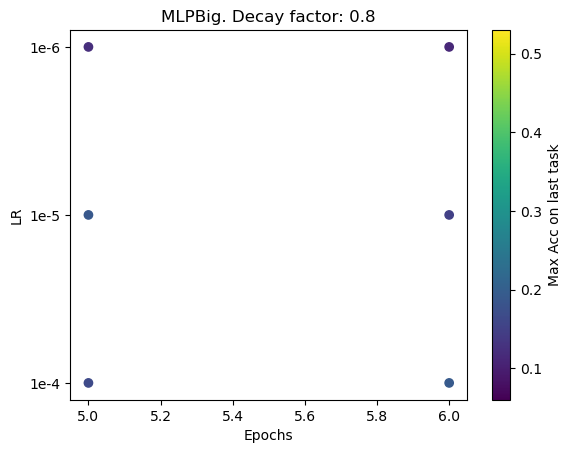

In [39]:
import numpy as np 

epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
epochs_list = [5, 6]
lr_list = [1e-4, 1e-5, 1e-6]
decay_list = [0.8]
models_list = [Efficient_KAN_Fixall(strategy, device)]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path)
in_path = os.path.join(path, 'trainings')
output_path = os.path.join(path, 'plots', 'scatter')

if not os.path.exists(output_path):
    os.makedirs(output_path)


for model in models_list:
    results = get_results(decay_list, lr_list, epochs_list, model.__class__.__name__, in_path)
    results.sort(key = lambda x: x[2])
    data_array = np.array(results)

    e_per_dec = len(lr_list)*len(epochs_list)
    for i, decay_f in enumerate(decay_list):

        # Separate into x, y, z coordinates
        x = data_array[e_per_dec*i:e_per_dec*(i+1), 0]   # epochs
        y = data_array[e_per_dec*i:e_per_dec*(i+1), 1]   # lrs
        z = data_array[e_per_dec*i:e_per_dec*(i+1), 3]   # max acc
        y = [f"1e{round(math.log10(lr))}" for lr in y]
        # Create scatter plot with z values as color gradient
        plt.scatter(x, y, c=z, cmap='viridis', vmin=0.06, vmax=0.53)  # 'viridis' is one of the colormap options
        # Add a colorbar to show the mapping between z values and colors
        plt.colorbar(label='Max Acc on last task')

        # Labels
        plt.xlabel('Epochs')
        plt.ylabel('LR')
        
        # Show plot
        plt.title(f"{name}. Decay factor: {decay_f}")
        plt.show()
        plt.savefig(os.path.join(output_path, f"dec{decay_f}_{name}.png"))
        plt.close()

### Actual 3D plot

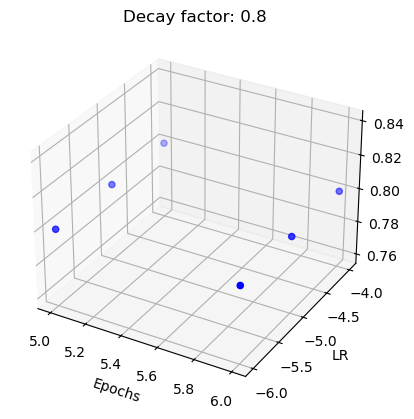

In [41]:
import numpy as np 

epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
epochs_list = [5, 6]
lr_list = [1e-4, 1e-5, 1e-6]
decay_list = [0.8]
models_list = [Efficient_KAN_Fixall(strategy, device)]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path)
in_path = os.path.join(path, 'trainings')
output_path = os.path.join(path, 'plots', '3d')

if not os.path.exists(output_path):
    os.makedirs(output_path)
    
for model in models_list:
    results = get_results(decay_list, lr_list, epochs_list, model.__class__.__name__, in_path)
    data_array = np.array(results)

    # Separate into x, y, z coordinates
    x = data_array[:, 0]  # First element of each array (independent variable 1)
    y = data_array[:, 1]  # Second element of each array (independent variable 2)
    z = data_array[:, 2]  # Third element of each array (dependent variable)

    y = [round(math.log10(lr)) for lr in y]
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(x, y, z, c='b', marker='o')

    # Labels
    ax.set_xlabel('Epochs')
    ax.set_ylabel('LR')
    
    # Show plot
    plt.title(f"Decay factor: {decay_f}")
    plt.show()
    plt.close()

# Confusion Matrices

In [43]:
import numpy as np 

epoch_sched = False
reverse_taks = False
strategy = "classIL"
longer_last_tasks = False
reverse_taks = False

reverse_path = ""
if reverse_taks:
    reverse_path = "reverse_tasks"
longer_last_path = ""
if longer_last_tasks:
    longer_last_path = "longer_last_tasks"
    
epochs_list = [5, 6]
lr_list = [1e-4, 1e-5, 1e-6]
decay_list = [0.8]
models_list = [Efficient_KAN_Fixall(strategy, device)]
names = ["EffKAN Fix"]

path = os.path.join('..', 'results', 'mnist') # remove 'convs' if MLP
path = os.path.join(path, strategy, longer_last_path, reverse_path)
in_path = os.path.join(path, 'trainings')
output_path = os.path.join(path, 'plots', 'conf_matrices')
if not os.path.exists(output_path):
    os.makedirs(output_path)
    
for idx, model in enumerate(models_list):
    for epochs in epochs_list:
        for lr in lr_list:
            for decay_f in decay_list:
                lr_decay = True
                if decay_f == 1:
                    lr_decay = False
                str_epoch = f"ep{epochs}" 
                str_epoch += 'sched' if epoch_sched else ''
                str_decay = '_dec'+ str(decay_f) if lr_decay else ''
                str_lr = f"_lr{round(math.log10(lr))}"
                name = model.__class__.__name__
                stats = EpochStat.loadModelStats(dir=in_path, name=name, subdir=os.path.join(f"{str_epoch}{str_lr}{str_decay}", name))
                
                plt.rc('font', size=18)
                for stat in stats[:]:
                    cm = confusion_matrix(stat.labels, stat.predictions, labels=range(10))
                    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
                    disp.plot()
                    fig = disp.ax_.get_figure()
                    fig.set_figwidth(8)
                    fig.set_figheight(8)
                    plt.figtext(0.445, 0.85, f"{names[idx]} - Epoch: {stat.epoch}", ha='center', fontsize=22)
                    name = model.__class__.__name__
                    if not os.path.exists(os.path.join(output_path, f"{name}_{str_epoch}{str_lr}{str_decay}")):
                        os.makedirs(os.path.join(output_path, f"{name}_{str_epoch}{str_lr}{str_decay}")) 
                    # print(os.path.join(output_path, f"{names[idx]}{str_lr}{str_decay}"))                                     
                    fig.savefig(os.path.join(output_path, f"{name}_{str_epoch}{str_lr}{str_decay}", f"ep{stat.epoch}.png"))
                    plt.close()